In [ ]:
#==============================================Generating Mask Script=========================================================================
import cv2
import os
import json
import random
import shutil
from tqdm import tqdm
import numpy as np

CLASS_ID_TO_VALUE = {
    "head": 50,
    "body": 100,
    "leg": 150,
    "tail": 200
}

category_id_to_name = {cat['id']: cat['name'] for cat in categories}

def generate_masks(split):
    split_path = os.path.join(OUTPUT_DIR, split)
    annot_file = os.path.join(split_path, 'annotations.json')
    with open(annot_file, 'r') as f:
        data = json.load(f)

    img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    masks_path = os.path.join(split_path, 'masks')

    for img in tqdm(data['images'], desc=f'Generating masks for {split}'):
        mask = np.zeros((640, 640), dtype=np.uint8)  # Fixed size from preprocessing
        filename = img['file_name']

        for ann in data['annotations']:
            if ann['image_id'] != img['id']:
                continue
            category_name = category_id_to_name[ann['category_id']]
            if category_name not in CLASS_ID_TO_VALUE:
                continue
            x, y, w, h = map(int, ann['bbox'])
            cv2.rectangle(mask, (x, y), (x + w, y + h), CLASS_ID_TO_VALUE[category_name], thickness=-1)

        cv2.imwrite(os.path.join(masks_path, filename.replace('.jpg', '.png')), mask)

for split in ['train', 'val', 'test']:
    generate_masks(split)


Generating masks for test: 100%|██████████| 255/255 [00:02<00:00, 88.63it/s]


In [ ]:
#===========================================================DataSet Visualization===========================================================================================

import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import os

OUTPUT_DIR = '/content/gdrive/MyDrive/Art2DataV1/cow_dataset_split'  # DataSet Link

def visualize_sample(split='train', num_samples=5):
    images_dir = os.path.join(OUTPUT_DIR, split, 'images')
    masks_dir = os.path.join(OUTPUT_DIR, split, 'masks')

    image_files = os.listdir(images_dir)
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    for img_file in samples:
        # ✅ Load image
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ✅ Load and preprocess mask
        mask_path = os.path.join(masks_dir, img_file.replace('.jpg', '.png'))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ✅ Exclude background (0)
        mask_display = mask.copy()
        mask_display[mask_display == 0] = 255

        # ✅ Apply colormap only to non-background
        color_mask = cv2.applyColorMap(mask_display, cv2.COLORMAP_JET)

        # ✅ Mask out the colormap background effect
        binary_mask = (mask > 0).astype(np.uint8)
        binary_mask_3ch = np.stack([binary_mask]*3, axis=-1)
        color_mask = color_mask * binary_mask_3ch

        overlay = cv2.addWeighted(img_rgb, 1.0, color_mask, 0.6, 0)

        # ✅ Plot
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Overlay (No Background)")
        plt.imshow(overlay)
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
visualize_sample(split='train', num_samples=3)

In [4]:
# ===============================
# Model Architecture & Training
# ===============================

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import random
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

class ResNetBackbone(nn.Module):
    def __init__(self, backbone='resnet50', pretrained=True):
        super().__init__()

        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
        elif backbone == 'resnet101':
            resnet = models.resnet101(pretrained=pretrained)
        else:
            raise ValueError("Unsupported backbone")

        self.layer0 = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1  # Low-level features
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4  # High-level features

    def forward(self, x):
        x = self.layer0(x)
        low_level = self.layer1(x)
        x = self.layer2(low_level)
        x = self.layer3(x)
        high_level = self.layer4(x)
        return low_level, high_level


# ===============================
# ASPP (Atrous Spatial Pyramid Pooling)
# ===============================

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.image_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.out = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.shape[2:]

        img_pool = self.image_pool(x)
        img_pool = self.image_conv(img_pool)
        img_pool = nn.functional.interpolate(img_pool, size=size, mode='bilinear', align_corners=False)

        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)

        x = torch.cat([x1, x2, x3, x4, img_pool], dim=1)
        return self.out(x)


# ===============================
# Multi-Scale Attention Module (MSAM)
# ===============================

class MSAM(nn.Module):
    def __init__(self, channels):
        super(MSAM, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 8, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 8, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


# ===============================
# Fusion + Decoder Head + Final Segmentation Model
# ===============================

class CowSegmentationModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.backbone = ResNetBackbone(backbone='resnet50', pretrained=True)
        self.aspp = ASPP(in_channels=2048, out_channels=256)
        self.attention = MSAM(channels=256)

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, n_classes, kernel_size=1)
        )

    def forward(self, x):
        low_level, high_level = self.backbone(x)
        x = self.aspp(high_level)
        x = self.attention(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        x = self.decoder(x)
        x = F.interpolate(x, size=(640, 640), mode='bilinear', align_corners=False)
        return x


# ===============================
# Training Setup
# ===============================

def get_optimizer(model, lr=1e-4):
    return optim.Adam(model.parameters(), lr=lr)

def loss_fn(pred, target):
    return F.cross_entropy(pred, target)

def get_scheduler(optimizer):
    return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def pixel_accuracy(output, mask):
    with torch.no_grad():
        preds = torch.argmax(output, dim=1)
        correct = (preds == mask).float()
        return correct.sum() / correct.numel()


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    acc_total = 0.0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        acc_total += pixel_accuracy(outputs, masks).item()

    return running_loss / len(dataloader), acc_total / len(dataloader)


def validate_one_epoch(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    acc_total = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            running_loss += loss.item()
            acc_total += pixel_accuracy(outputs, masks).item()

    return running_loss / len(dataloader), acc_total / len(dataloader)


# ===============================
# Dataset
# ===============================

class CowPartsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name.replace('.jpg', '.png'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(mask).long()

        mask = torch.where(mask == 50, 1, mask)
        mask = torch.where(mask == 100, 2, mask)
        mask = torch.where(mask == 150, 3, mask)
        mask = torch.where(mask == 200, 4, mask)

        return image, mask


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


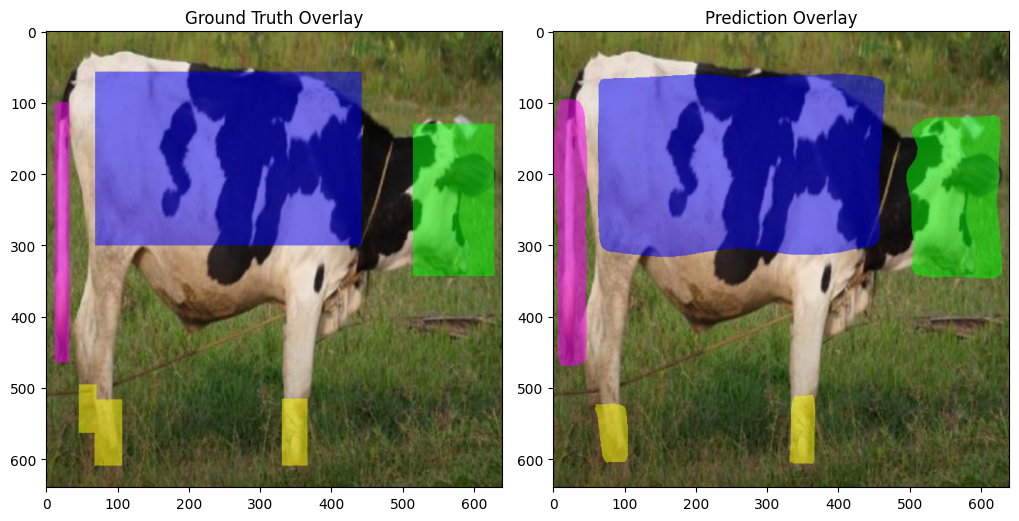

In [6]:
#===============================================Evaluate on TestSet Samples================================================================
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# ✅ Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Specify your checkpoint path
checkpoint_path = "...../best_model.pth" # <--- Update it

# ✅ Re-create model and load weights
model = CowSegmentationModel(n_classes=5).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# ✅ Image and mask paths

sample_path = "........../test/images/Cow522_jpg.rf.0753b397f789498c492653928ca1b49e.jpg"   # <--- Update it

mask_path = sample_path.replace('images', 'masks').replace('.jpg', '.png')

# ✅ Load and preprocess
image = cv2.imread(sample_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_tensor = transforms.ToTensor()(image_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# ✅ Original mask
true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# ✅ Remap to class indices
true_mask = np.where(true_mask == 50, 1, true_mask)
true_mask = np.where(true_mask == 100, 2, true_mask)
true_mask = np.where(true_mask == 150, 3, true_mask)
true_mask = np.where(true_mask == 200, 4, true_mask)


# ✅ Color mapping (BGR for OpenCV)
colors = {
    1: (0, 255, 0),      # Head - Green
    2: (255, 0, 0),      # Body - Blue
    3: (0, 255, 255),    # Leg - Yellow
    4: (255, 0, 255),    # Tail - Magenta
    # 0: background
}

def overlay_segmentation(image, mask, alpha=0.5):
    overlay = image.copy()
    for class_id, color in colors.items():
        overlay[mask == class_id] = color
    blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    return blended

# ✅ Prepare overlays
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
gt_overlay = overlay_segmentation(image_bgr, true_mask)
pred_overlay = overlay_segmentation(image_bgr, pred)

# ✅ Convert to RGB for matplotlib
gt_overlay_rgb = cv2.cvtColor(gt_overlay, cv2.COLOR_BGR2RGB)
pred_overlay_rgb = cv2.cvtColor(pred_overlay, cv2.COLOR_BGR2RGB)

# ✅ Plot
plt.figure(figsize=(15,5))
#plt.subplot(1,3,1)
#plt.imshow(image_rgb)
#plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(gt_overlay_rgb)
plt.title("Ground Truth Overlay")

plt.subplot(1,3,3)
plt.imshow(pred_overlay_rgb)
plt.title("Prediction Overlay")

plt.tight_layout()
plt.show()
